# Quantum Approximate Optimization Algorithm (QAOA) for Phylogenetic Trees

---

In this notebook, we are going to use Qiskit to solve the needed optimization problem to reconstruct Phylogenetic Trees. This work will be based in 2 documents, a book that describes QAOA [1], and the paper for reconstruction of Phylogenetic Trees [2].



[1] Combarro, E. F., & Gonzalez-Castillo, S. (2023). A practical guide to quantum machine learning and quantum optimisation: Hands-On Approach to Modern Quantum Algorithms. Packt Publishing.

[2] Onodera, W., Hara, N., Aoki, S., Asahi, T., & Sawamura, N. (2022). Phylogenetic tree reconstruction via graph cut presented using a quantum-inspired computer. Molecular Phylogenetics and Evolution, 178, 107636. https://doi.org/10.1016/j.ympev.2022.107636

In [1]:
from qa_functions import *
from qaoa_functions import *
import time
import re
from qiskit.visualization import plot_histogram
import dask
from distributed import Client
import os

Firstly, we need to transform the expression of the BQM to a Ising Hamiltonian, to do this, we'll make use of D-Wave functions. After we have the Ising Hamiltonian, we'll parse the expression in the way we need it.

In [3]:
matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])

# Function to get the needed expression to create a QAOA
def prepare_exp(matrix:np.ndarray,c=0):
    r"""
    Prepares the Hamiltonian needed for the QAOA circuit
    
    Args:
        `matrix` (np.ndarray): Numpy array containing the simmetric (or lower triangular matrix) that defines the problem.
        `c` (int): Number of non-zero variables.
        `tags` (list): Defines the name of the variables. **MUST BE AN INT LIST**
        
    Returns:
        The expression as a string.        
    """
    
    
    alpha = matrix.shape[0]*100
    h, J, _ = min_cut_c(matrix,c=c,alpha=alpha).to_ising()
    # print(f'Linar coeffs: {h}')
    # print(f'Quadratic terms: {J}')
    exp = ""

    for term in J:
        exp+="+"+str(J[term])+"Z"+str(term[0])+"Z"+str(term[1])

    for term in h:
        if h[term]>0:
            exp+="+"+str(h[term])+"Z"+str(term)
        elif h[term]<0:
            exp+=str(h[term])+"Z"+str(term)
            
    return exp 

def combine_inverse_keys(original_dict):
    """
    Combines the reciprocal solutions as only one solution
    """
    new_dict = {}
    
    for key, value in original_dict.items():
        # Compute the inverse key
        inverse_key = ''.join('1' if bit == '0' else '0' for bit in key)
        
        # Sort the pair to ensure consistent representation
        combined_key = min(key, inverse_key)
        
        # Add value to the combined key
        if combined_key in new_dict:
            new_dict[combined_key] += value
        else:
            new_dict[combined_key] = value
    
    return new_dict

def get_bes_sol(qc:QuantumCircuit)->dict:
    """   Runs the quantic circuit simulation and returns the value with more counts   """
    sim = AerSimulator()

    # Transpile the circuit for the simulator or real QPU
    qc.measure_all()
    qc = transpile(qc,sim)

    # Run the circuit and collect results
    sampler = SamplerV2()
    job = sampler.run([qc],shots=2048)
    job_result = job.result()
    counts=job_result[0].data.meas.get_counts()
    n_counts = combine_inverse_keys(counts)
    best = max(n_counts,key=n_counts.get)
    return best

exp = prepare_exp(matrix,c=1)
print(exp)

+204.0Z0Z1+239.5Z2Z1+213.5Z2Z0+225.5Z3Z1+211.0Z3Z0+232.5Z3Z2+233.0Z4Z1+204.0Z4Z0+218.5Z4Z2+235.5Z4Z3+750.0Z1+750.0Z0+750.0Z2+750.0Z3+750.0Z4


Using the `phylo_tree` function from [qa_functions.py](qa_functions.py) as a base, we can use QAOA instead of the QA that we used before. We also need to change the way the solution and the tags will be used.

In [3]:
def qaoa_phylo_tree(matrix:np.ndarray,tags=[],**kwargs):
    r"""
    Recursive function that uses QAOA to create the Phylogenetic tree using Ncut
    
    Args:
        `matrix`: The matrix defining the graph.
        `tags`: Tags defining the names of the nodes, used for recursivity. **MUST BE AN INT LIST**
    Returns:
        The `TreeNode` containing the full tree. 
    """
    ncuts = []
    n_graph_0 = []
    n_graph_1 = []
    
    if not tags:
        sub_mat = matrix
        tags = list(range(matrix.shape[0]))
    else:
        sub_mat = matrix[np.ix_(tags, tags)]
        
    rows = sub_mat.shape[0]
    
    var = int(np.floor(rows/2.0))+1

    # Run min_cut for each configuration
    for i in range(1,var):
        print(f'Corte con {i}')
        if 'timer' in kwargs:
            start = time.time_ns()/1000000
        # Prepare the expression and run the QAOA    
        problem = prepare_exp(sub_mat,c=i)
        qaoa = QAOA(problem,rows)
        qaoa.get_opt_circ()
        result = get_bes_sol(qaoa.qc)
                
        # Time measurement
        if 'timer' in kwargs:
            end = time.time_ns()/1000000
            kwargs['timer'].update(end-start)
            
        n_graph_0.append([tags[j] for j in range(len(result)) if result[j]=='0'])
        n_graph_1.append([tags[j] for j in range(len(result)) if result[j]=='1'])        
        print(f'\tLa division es: {n_graph_0[i-1]} | {n_graph_1[i-1]}')
        
        if not n_graph_0[i-1] or not n_graph_1[i-1]:
            n_graph_0.pop()
            n_graph_1.pop()
        else:
            ncuts.append(n_cut(qaoa.min,n_graph_0[i-1],n_graph_1[i-1],matrix))
        
    
    # Get the cuts created by the minimum ncut value
    index = np.argmin(ncuts)
    print(f'Se selecciona la separacion: {n_graph_0[index]} | {n_graph_1[index]}')
    
    node = TreeNode(tags)
    
    # Recursivity in the first graph
    if len(n_graph_0[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(qaoa_phylo_tree(matrix,tags=n_graph_0[index],timer=kwargs['timer']))
        else:
            node.children.append(qaoa_phylo_tree(matrix,tags=n_graph_0[index]))
    else:
        leaf = TreeNode(n_graph_0[index])
        if len(n_graph_0[index]) == 2:
            leaf.children.append(TreeNode([n_graph_0[index][0]]))
            leaf.children.append(TreeNode([n_graph_0[index][1]]))
        node.children.append(leaf)
        
    # Recursivity in the first graph
    if len(n_graph_1[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(qaoa_phylo_tree(matrix,tags=n_graph_1[index],timer=kwargs['timer']))
        else:
            node.children.append(qaoa_phylo_tree(matrix,tags=n_graph_1[index]))
    else:
        leaf = TreeNode(n_graph_1[index])
        if len(n_graph_1[index]) == 2:
            leaf.children.append(TreeNode([n_graph_1[index][0]]))
            leaf.children.append(TreeNode([n_graph_1[index][1]]))
        node.children.append(leaf)
    
    return node

Corte con 1
	La division es: [0, 2] | [1, 3, 4]
Corte con 2
	La division es: [0, 1, 3] | [2, 4]
Se selecciona la separacion: [0, 1, 3] | [2, 4]
Corte con 1
	La division es: [0, 3] | [1]
Se selecciona la separacion: [0, 3] | [1]
El tiempo utilizado es: 3923.107666015625


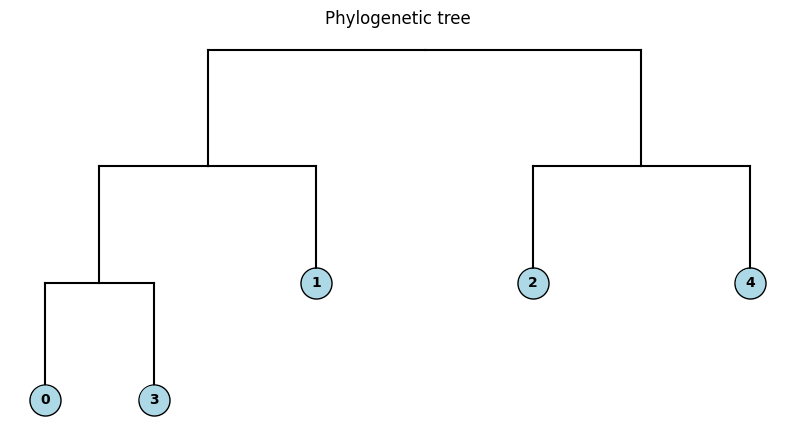

In [4]:
timer = Timer(0.0)
matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])
tree = qaoa_phylo_tree(matrix,timer=timer)
print(f'El tiempo utilizado es: {timer}')
tree.display_tree()

The QAOA does whatever it likes and it has a really high variability. We can explore this in especific examples, for example let's take the first iteration of `qaoa_phylo_tree` ($c=1$). Using this setup, we should get a solution with only one of the variables as 1.

-79.509765625 [ 8.65375171e-05 -5.01124550e-05]
[ 8.65375171e-05 -5.01124550e-05]
11010 -79.509765625


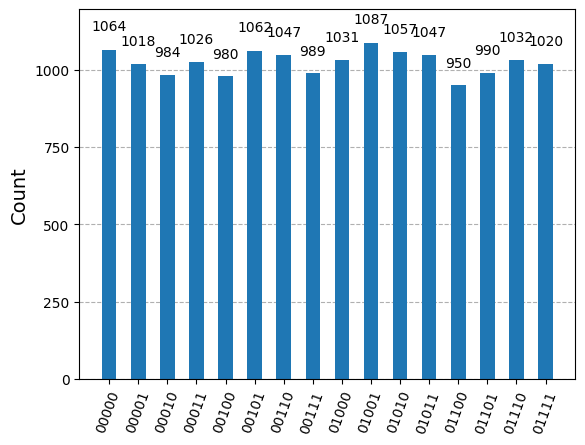

In [7]:
problem = prepare_exp(matrix,c=1)
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1
qaoa = QAOA(problem,size,x0=[0.0,0.0],method='COBYLA')
qaoa.get_opt_circ()
print(qaoa.param)
sim = AerSimulator()

# Transpile the circuit for the simulator or real QPU
qaoa.qc.measure_all()
qc = transpile(qaoa.qc,sim)

# Run the circuit and collect results
sampler = SamplerV2()
job = sampler.run([qaoa.qc],shots=16384)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
print(max(counts,key=counts.get),qaoa.min)
comb_counts = combine_inverse_keys(counts)
plot_histogram(comb_counts)

In [6]:
params = []
minim = []

act_min = np.inf
j=0
problem = prepare_exp(matrix,c=1)
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1

for i in range(100):
    initial_guess = np.random.random(2)
    qaoa = QAOA(problem,size,x0=initial_guess)
    qaoa.get_min()
    params.append(qaoa.param)
    minim.append(qaoa.min)
    if qaoa.min< act_min:
        act_min = qaoa.min
        arg = qaoa.param
        j=i
        print(f'El nuevo minimo es {act_min} con {arg}')
    
print(f'El minimo es: {act_min}, y se da con los parametros: {arg}')
print(f'Se da el minimo en la iteracion {j}')

El nuevo minimo es -779.533203125 con [1.3021688  0.73540331]
El nuevo minimo es -930.546875 con [ 2.00104279 -0.96595888]
El nuevo minimo es -1071.9072265625 con [1.07992747 0.87563176]
El nuevo minimo es -1352.6220703125 con [1.94872681 0.76933921]
El minimo es: -1352.6220703125, y se da con los parametros: [1.94872681 0.76933921]
Se da el minimo en la iteracion 24


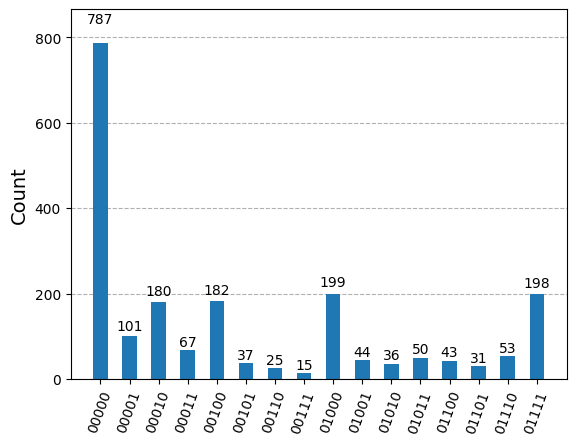

In [5]:
qc = create_ansatz(problem,size,1,[arg[0]],[arg[1]])
sim = AerSimulator()

# Transpile the circuit for the simulator or real QPU
qc.measure_all()
qc = transpile(qc,sim)

# Run the circuit and collect results
sampler = SamplerV2()
job = sampler.run([qc],shots=2048)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
n_counts = combine_inverse_keys(counts)
plot_histogram(n_counts)

In [81]:
qc = create_ansatz(problem,size,1,[arg[0]],[arg[1]])

# Define the grid for plotting
x = np.linspace(-2, 2, 100)
y = np.linspace(-2, 2, 100)
Z = {}

for i in x:
    for j in y:
        qc = create_ansatz(problem,size,1,[i],[j])
        Z[(i,j)] = get_energy(qc,problem)

In [86]:
min(Z,key=Z.get)
Z[(np.float64(-0.02020202020202011), np.float64(-0.5858585858585856))]

np.float64(-997.326171875)

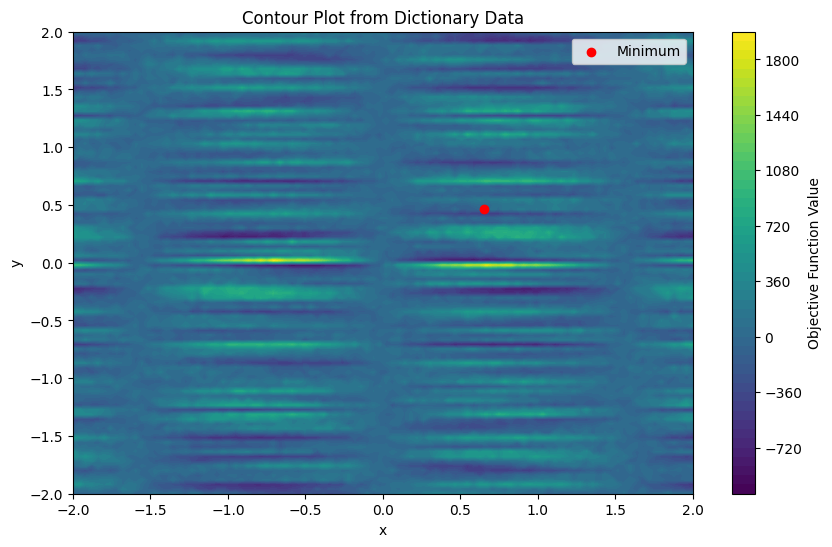

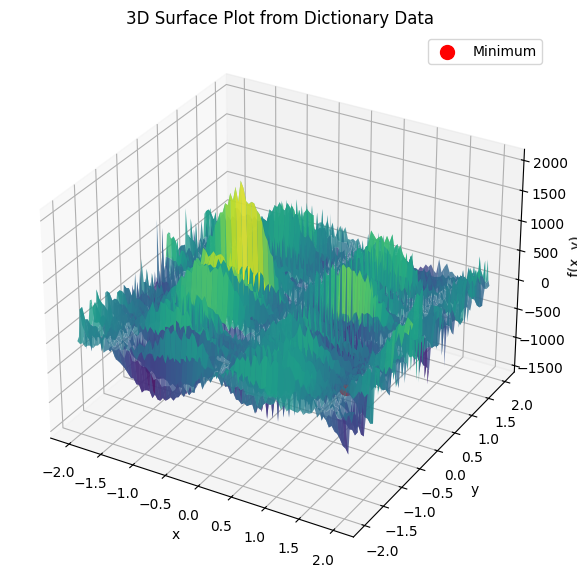

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
%matplotlib inline
coords = np.array(list(Z.keys()))
x = coords[:, 0]
y = coords[:, 1]
z = np.array(list(Z.values()))

# Create a grid for plotting
x_unique = np.unique(x)
y_unique = np.unique(y)
X, Y = np.meshgrid(x_unique, y_unique)

# Reshape z values into the grid
Z_grid = np.zeros_like(X, dtype=float)
for i in range(len(x)):
    xi, yi = x[i], y[i]
    Z_grid[np.where(x_unique == xi), np.where(y_unique == yi)] = z[i]

# Plot the contour
plt.figure(figsize=(10, 6))
contour = plt.contourf(X, Y, Z_grid, levels=50, cmap='viridis')
plt.colorbar(contour, label='Objective Function Value')
plt.scatter(0.65444527, 0.46155226, color='red', label='Minimum', zorder=5)  # Example minimum
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Contour Plot from Dictionary Data')
plt.show()

%matplotlib inline
# Optional: 3D Surface Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z_grid, cmap='viridis', alpha=0.8)
ax.scatter(0.65444527,0.46155226, -1369.1376953125, color='red', s=100, label='Minimum')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('f(x, y)')
ax.set_title('3D Surface Plot from Dictionary Data')
plt.legend()
plt.show()

## Problems

Using this approach we've come to a problem. Due to the nature of the landscape, finding a good minimum may be difficult, so the optimizer stops in suboptimal parameters getting mostly wrong solutions. To fix this, we can try other optimizers that get the minimum parameters often. If using gradient descent doesn't work we can try other methods like differential evolution, or other ones.

- One thing I can do is to use multiprocessing and COBYLA together to run multiple optimizations and get the best one.

In [4]:
from scipy.optimize import differential_evolution
from multiprocessing import Pool

pool = Pool(8)
parameters={'maxiter':10000,
           'popsize':8,
           'workers':pool.map,
           'polish':False,
           'strategy':'best1exp',
           'updating':'deferred'}
problem = prepare_exp(matrix,c=1)
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1
qaoa = QAOA(problem,size)

bounds = [(-2, 2), (-2, 2)]

result = differential_evolution(qaoa.objective,bounds,**parameters)
print(result.x)
print(result.fun)

[-0.00692166 -0.75751364]
-3876.2939453125


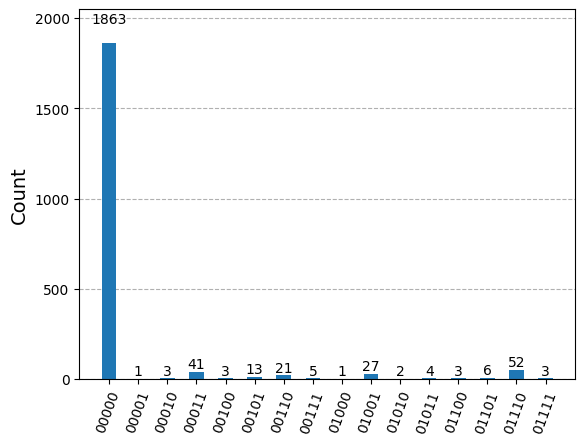

In [5]:
qc = create_ansatz(problem,size,1,[result.x[0]], [result.x[1]])
sim = AerSimulator()

# Transpile the circuit for the simulator or real QPU
qc.measure_all()
qc = transpile(qc,sim)

# Run the circuit and collect results
sampler = SamplerV2()
job = sampler.run([qc],shots=2048)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
n_counts = combine_inverse_keys(counts)
plot_histogram(n_counts)

### Qiskit QAOA


In [ ]:
# from qiskit_algorithms.utils import algorithm_globals
# from qiskit_algorithms import QAOA
# from qiskit_algorithms.optimizers import SPSA
# from docplex.mp.model import Model
# from qiskit.primitives import Sampler

# from qiskit_optimization.algorithms import MinimumEigenOptimizer
# from qiskit_optimization.translators import from_docplex_mp

# model = Model()
# sampler = Sampler()
# size = matrix.shape[0]

# x = model.binary_var_list(size)

# model.minimize(model.sum(matrix[i,j]*(x[i]-x[j])**2 for i in range(size) for j in range(size))-5000*model.sum((x[i] -1)**2 for i in range(size)))

# problem = from_docplex_mp(model)

# spsa = SPSA(maxiter=250)
# qaoa = QAOA(sampler, spsa, reps=5)
# algorithm = MinimumEigenOptimizer(qaoa)
# result = algorithm.solve(problem)
# print(result.prettyprint())

C:\Users\nicolas.fernandez\AppData\Local\Temp\ipykernel_16732\2876752325.py:11: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  sampler = Sampler()


objective function value: -25000.0
variable values: x0=0.0, x1=0.0, x2=0.0, x3=0.0, x4=0.0
status: SUCCESS


# Multiprocessing

I have 1 idea: ✨**Parallelization**✨. I can run as much processes as I have threads and use the minimum of those processes. This will take approximately the same time as 1 run but we get $N$ executions. This obviously only works for a simulator as as of now it is impossible to parellelize works in a QPU.

In [ ]:
import multiprocessing
from multiprocessing import Pool, Process, Queue, Manager

# Standalone function for calling get_min
def call_get_min(instance):
    print('hola')
    return instance.get_min()

# External parallelization function
def parallel_minimization(instances:QAOA):
    with Pool(processes=len(instances)) as pool:
        # Use pool to call get_min on each instance
        results = pool.map(call_get_min, instances)
    return results

if __name__ == '__main__':
    
            
    matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])
    problem = prepare_exp(matrix,c=1)
    size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1
    
    poolsize = multiprocessing.cpu_count()
    instances = [QAOA(problem,size) for _ in range(poolsize)]
    
    results = parallel_minimization(instances)
        
    print('Results:',results)

In [4]:
import pickle


matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])
problem = prepare_exp(matrix,c=1)
obj = QAOA(problem,5)
try:
    pickle.dumps(obj)
    print("Serialization successful!")
except Exception as e:
    print("Serialization failed:", e)

Serialization successful!


In [ ]:
from multiprocessing import Pool, get_context

def simple_function(x):
    return x ** 2

if __name__ == "__main__":
    ctx = get_context('spawn')
    with Pool(processes=4) as pool:
        inputs = [1, 2, 3, 4]
        results = pool.map(simple_function, inputs)
    print("Results:", results)

In [ ]:
from ipyparallel import Client
import multiprocessing

rc = Client()

def simple_function(x):
    return x ** 2

def call_get_min(instance):
    return instance.get_min()


lb_view = rc.load_balanced_view()

matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])
problem = prepare_exp(matrix,c=1)
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1

poolsize = multiprocessing.cpu_count()
instances = [QAOA(problem,size) for _ in range(8)]
results = lb_view.map_sync(call_get_min, instances)
print("Results:", results)

## TODO:

- Make this work
- Test this using $N$ threads (tomorrow in my house i have at least 12 threads)
- Test this in compute CESGA
- Test this approach in PhyloTrees (make it an optional arg like in scipy)
- DASK

Welp, we have a small problem. If the size of the parellelization is higher than 10 it totally breaks. Also, we cannot try the parallelization with multiprocessing directly in jupyter because of problems of the `__main__` context. I tried `ipyparallel` and it works, however, it has the same problem.

If we use this small problem the parallelization is worthless, however, for bigger problems, the optimization gives quick and relatively good solutions.

We can try to use DASK

## DASK

In [21]:
client = Client(n_workers=8)
client
# client.close()

c:\Users\nicolas.fernandez\AppData\Local\Programs\Python\Python312\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 65531 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:65531/status,
Dashboard: http://127.0.0.1:65531/status,Workers: 8
Total threads: 8,Total memory: 31.87 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:65534,Workers: 8
Dashboard: http://127.0.0.1:65531/status,Total threads: 8
Started: Just now,Total memory: 31.87 GiB
Comm: tcp://127.0.0.1:49190,Total threads: 1
Dashboard: http://127.0.0.1:49203/status,Memory: 3.98 GiB
Nanny: tcp://127.0.0.1:49154,


In [24]:
def simple_function(j):
    qaoa = QAOA(problem,size)
    return qaoa.get_min()
matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])
# matrix = np.array([[ 0., 30., 17., 73., 33., 51.,  9.],
#        [30.,  0., 32., 99., 63., 99., 48.],
#        [17., 32.,  0., 80., 23.,  4.,  5.],
#        [73., 99., 80.,  0., 89., 13., 95.],
#        [33., 63., 23., 89.,  0., 68., 86.],
#        [51., 99.,  4., 13., 68.,  0., 15.],
#        [ 9., 48.,  5., 95., 86., 15.,  0.]])
num_problems= 8
problem = prepare_exp(matrix,c=1)
problems = [problem]*num_problems
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1
sizes = [size]*num_problems
result = [None for i in range(num_problems)]
layers = [1]*8
# for i in range(10):
instances = [QAOA(problem,size) for _ in range(num_problems)]
# print(instances)
futures = [client.submit(instance.get_min,pure=False) for instance in instances]

# Gather results as they complete
results = client.gather(futures)

# Do something with results
print(results)

[(np.float64(-685.9453125), array([1.20714085, 1.14086473])), (np.float64(-331.1083984375), array([0.99824328, 1.00458392])), (np.float64(-1129.1240234375), array([-0.20850636, -0.97889763])), (np.float64(-669.5576171875), array([1.24752129, 0.9461152 ])), (np.float64(-1383.263671875), array([-0.01341392,  0.99211276])), (np.float64(-486.060546875), array([0.9604818 , 1.14469447])), (np.float64(-854.4638671875), array([1.33113177, 0.8372761 ])), (np.float64(25.3955078125), array([-0.00184724, -0.00756064]))]


In [25]:
client.close()

Time used: 5.0503082275390625
Solution: (np.float64(-758.1591796875), array([1.13397798, 1.98297214]))
[1.13397798 1.98297214]


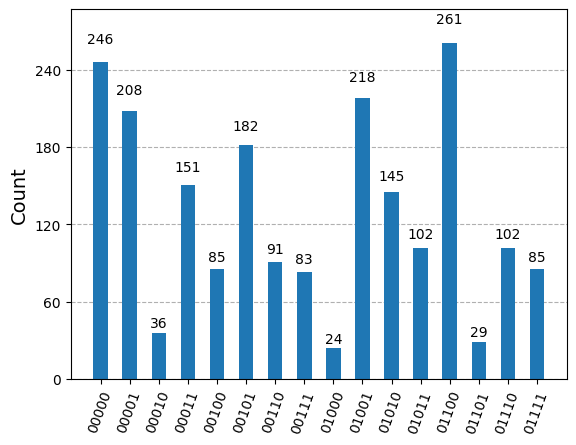

In [10]:
num_workers = 8
client = Client(n_workers=num_workers)


matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])

problem = prepare_exp(matrix,c=1)
size = max([int(x) for x in re.findall(r'Z([0-9]+)',problem)])+1

result = [None for i in range(num_workers)]
instances = [QAOA(problem,size) for _ in range(num_workers)]
start = time.time()
for i in range(num_workers):
    result[i]=instances[i].get_min()
    
cond_list = dask.compute(result)
end = time.time()
cond_list = cond_list[0]
best = min(cond_list)
print('Time used:',end-start)
print('Solution:',best)
best = best[1]
print(best)
client.close()
qc = create_ansatz(problem,size,1,[best[0]], [best[1]])
sim = AerSimulator()

# Transpile the circuit for the simulator or real QPU
qc.measure_all()
qc = transpile(qc,sim)

# Run the circuit and collect results 
sampler = SamplerV2()
job = sampler.run([qc],shots=2048)
job_result = job.result()
counts=job_result[0].data.meas.get_counts()
n_counts = combine_inverse_keys(counts)
plot_histogram(n_counts)
# plt.savefig('test_dask.png', bbox_inches='tight')

In [16]:
client = Client(scheduler_file='phylo_schedule.json')
client.scheduler_info()

{'type': 'Scheduler',
 'id': 'Scheduler-58fa9651-fa63-4276-bc84-6b83a22c56fc',
 'address': 'tcp://127.0.0.1:8786',
 'services': {'dashboard': 8787},
 'started': 1734517009.0594218,
 'workers': {'tcp://127.0.0.1:65441': {'type': 'Worker',
   'id': 'tcp://127.0.0.1:65441',
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': 'C:\\Users\\NICOLA~1.FER\\AppData\\Local\\Temp\\dask-scratch-space\\worker-uu7u3e3q',
   'name': 'tcp://127.0.0.1:65441',
   'nthreads': 1,
   'memory_limit': 4276941824,
   'last_seen': 1734517011.37793,
   'services': {'dashboard': 65442},
   'metrics': {'task_counts': {},
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'digests_total_since_heartbeat': {},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.02,
    'cpu': 0.0,
    'memory': 268480512,
    'time': 1734517011.355977,
    'host_net_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 0.0}},
   'status': 'running',
   'nanny': None},
  'tcp://127.0.0.1:65445': {'type': 'Worker',
   'id': 'tcp://127.0.0.1:65445',
   'host': '127.0.0.1',
   'resources': {},
   'local_directory': 'C:\\Users\\NICOLA~1.FER\\AppData\\Local\\Temp\\dask-scratch-space\\worker-87_1ggg5',
   'name': 'tcp://127.0.0.1:65445',
   'nthreads': 1,
   'memory_limit': 4276941824,
   'last_seen': 1734517012.3153546,
   'services': {'dashboard': 65446},
   'metrics': {'task_counts': {},
    'bandwidth': {'total': 100000000, 'workers': {}, 'types': {}},
    'digests_total_since_heartbeat': {},
    'managed_bytes': 0,
    'spilled_bytes': {'memory': 0, 'disk': 0},
    'transfer': {'incoming_bytes': 0,
     'incoming_count': 0,
     'incoming_count_total': 0,
     'outgoing_bytes': 0,
     'outgoing_count': 0,
     'outgoing_count_total': 0},
    'event_loop_interval': 0.02,
    'cpu': 0.0,
    'memory': 269975552,
    'time': 1734517012.3013604,
    'host_net_io': {'read_bps': 0.0, 'write_bps': 0.0},
    'host_disk_io': {'read_bps': 0.0, 'write_bps': 0.0}},
   'status': 'init',
   'nanny': None}}}

2024-12-18 11:18:36,262 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


## SOLUTION?

I have a strange error. When running the Dask cluster in Jupyter Notebook it works just fine. However, when running a python script it serializes the jobs. This makes absolutelly no sense. I will try to fix this, but we can try the Jupyter version for the moment. We will write the function that will be later incorporated into the main function.

In [2]:
def qaoa_phylo_tree_paral(matrix:np.ndarray,tags=[],**kwargs):
    r"""
    Recursive function that uses QAOA to create the Phylogenetic tree using Ncut
    
    Args:
        `matrix`: The matrix defining the graph.
        `tags`: Tags defining the names of the nodes, used for recursivity. **MUST BE AN INT LIST**
    Returns:
        The `TreeNode` containing the full tree. 
    """
    ncuts = []
    n_graph_0 = []
    n_graph_1 = []
    
    if not tags:
        sub_mat = matrix
        tags = list(range(matrix.shape[0]))
    else:
        sub_mat = matrix[np.ix_(tags, tags)]
        
    rows = sub_mat.shape[0]
    
    var = int(np.floor(rows/2.0))+1

    # Run min_cut for each configuration
    for i in range(1,var):
        # print(f'Corte con {i}')
        if 'timer' in kwargs:
            start = time.time_ns()/1000000
        sol = '0'*rows    
        
        while sol == '0'*rows:
            # Prepare the expression and run the QAOA    
            problem = prepare_exp(sub_mat,c=i)
            num_problems = len(client.scheduler_info()['workers'])
            instances = [QAOA(problem,rows) for _ in range(num_problems)]
            futures = [client.submit(instance.get_min,pure=False) for instance in instances]

            # Gather results as they complete
            results = client.gather(futures)
            
            best_tot = min(results)
            best = best_tot[1]
            minim = best_tot[0]
            qc = create_ansatz(problem,rows,phi=[best[0]],beta=[best[1]])
            sol = get_bes_sol(qc)
                
        # Time measurement
        if 'timer' in kwargs:
            end = time.time_ns()/1000000
            kwargs['timer'].update(end-start)
            
        n_graph_0.append([tags[j] for j in range(len(sol)) if sol[j]=='0'])
        n_graph_1.append([tags[j] for j in range(len(sol)) if sol[j]=='1'])        
        # print(f'\tLa division es: {n_graph_0[i-1]} | {n_graph_1[i-1]}')
        
        if not n_graph_0[i-1] or not n_graph_1[i-1]:
            n_graph_0.pop()
            n_graph_1.pop()
        else:
            ncuts.append(n_cut(minim,n_graph_0[i-1],n_graph_1[i-1],matrix))
        
    
    # Get the cuts created by the minimum ncut value
    index = np.argmin(ncuts)
    # print(f'Se selecciona la separacion: {n_graph_0[index]} | {n_graph_1[index]}')
    
    node = TreeNode(tags)
    
    # Recursivity in the first graph
    if len(n_graph_0[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(qaoa_phylo_tree_paral(matrix,tags=n_graph_0[index],timer=kwargs['timer']))
        else:
            node.children.append(qaoa_phylo_tree_paral(matrix,tags=n_graph_0[index]))
    else:
        leaf = TreeNode(n_graph_0[index])
        if len(n_graph_0[index]) == 2:
            leaf.children.append(TreeNode([n_graph_0[index][0]]))
            leaf.children.append(TreeNode([n_graph_0[index][1]]))
        node.children.append(leaf)
        
    # Recursivity in the first graph
    if len(n_graph_1[index]) > 2:
        if 'timer' in kwargs:
            node.children.append(qaoa_phylo_tree_paral(matrix,tags=n_graph_1[index],timer=kwargs['timer']))
        else:
            node.children.append(qaoa_phylo_tree_paral(matrix,tags=n_graph_1[index]))
    else:
        leaf = TreeNode(n_graph_1[index])
        if len(n_graph_1[index]) == 2:
            leaf.children.append(TreeNode([n_graph_1[index][0]]))
            leaf.children.append(TreeNode([n_graph_1[index][1]]))
        node.children.append(leaf)
    
    return node

In [2]:
client = Client(n_workers=16)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 15.82 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:49446,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 15.82 GiB
Comm: tcp://127.0.0.1:49539,Total threads: 1
Dashboard: http://127.0.0.1:49545/status,Memory: 0.99 GiB
Nanny: tcp://127.0.0.1:49449,


Corte con 1
Corte con 2
Corte con 1
Corte con 2
El tiempo utilizado es: 7981.05029296875


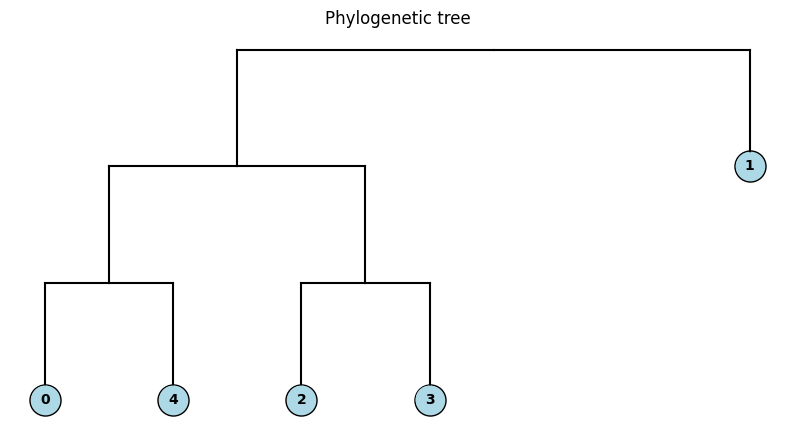

In [3]:
timer = Timer(0.0)
matrix = np.array( [[ 0, 92, 73, 78, 92],
                    [92,  0, 21, 49, 34],
                    [73, 21,  0, 35, 63],
                    [78, 49, 35,  0, 29],
                    [92, 34, 63, 29,  0]])
tree = qaoa_phylo_tree(matrix,client=client,timer=timer)
print(f'El tiempo utilizado es: {timer}')
tree.display_tree()

OK, let's test this for the creation of a real tree. We will start with size 25, it will probably take a while.

In [3]:
# slice_alignment("alignments/COG9.sim.p",10)
file = "alignments/test/COG9.sim._sliced_10.p" 
# output_file = "distance_matrix.csv"

sequences,labels = load_sequences(file,format='phylip')
distance_matrix = compute_distance_matrix(sequences)
print(labels)

['N1', 'N98', 'N49', 'N192', 'N26', 'N105', 'N147', 'N159', 'N96', 'N194']


In [5]:
timer = Timer(0.0)
tree = qaoa_phylo_tree(distance_matrix,client=client,timer=timer)
print(f'El tiempo utilizado es: {timer}')
tree.display_tree(tree_size=4)

IndexError: list index out of range

In [7]:
client.close()

# Testing

After the work done before, we can start testing the method using different trees. For each tree, `qaoa_phylo_tree` will be used to create the best phylogenetic tree. After each tree, a newick file will be created in the corresponding folder, where it can be easily compared using RF distance.

In [8]:
client = Client(n_workers=16)
client

c:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 50565 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:50565/status,
Dashboard: http://127.0.0.1:50565/status,Workers: 16
Total threads: 16,Total memory: 15.82 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:50566,Workers: 16
Dashboard: http://127.0.0.1:50565/status,Total threads: 16
Started: Just now,Total memory: 15.82 GiB
Comm: tcp://127.0.0.1:50642,Total threads: 1
Dashboard: http://127.0.0.1:50656/status,Memory: 0.99 GiB
Nanny: tcp://127.0.0.1:50569,


In [4]:
file_names = os.listdir('matrices')

for folder in file_names:
    files = os.listdir(f'matrices/{folder}')
    for file in files:
        # Load the sequences
        distance_matrix = np.load(f'./matrices/{folder}/{file}')

        print(f'Generating tree from: {file}')
        # Create the tree
        timer = Timer(0.0)
        tree_qaoa = qaoa_phylo_tree(distance_matrix,client=client,timer=timer)

        with open('timer.csv','a') as fp:
            fp.write(f'{folder},{file},{timer.value}\n')

        file_ext = re.search(r'_([0-9]+)\.',file).group(1)
        new_file = f'qaoa_tree_{file_ext}.newick'
        tree_qaoa.create_newick_file(f'./trees/{folder}/{new_file}')
        print(f'Finished {file} in {timer.value}ms')

        del sequences
        del labels
        del distance_matrix

Generating tree from: matrix_10618.npy


KeyboardInterrupt: 